In [467]:
# load a matrix from a space-separated file and show it as an image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch



In [468]:
def load_adaptation_trace(file_path): 
        df = pd.read_csv(file_path)
        arr = df.Adaptation.to_numpy()
        return arr

In [469]:
LOSS_IS_PER_SAMPLE = False
result_root = '/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/'
coin_bics_path = '/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/coin_bics1000.txt'
paradigm_ = {k: 'evoked' if k <= 8 else 'spontaneous' for k in range(1,17)}
coin_bics = np.loadtxt(coin_bics_path)
# exp_datasets = [ load_adaptation_trace(f'/homes/ar2342/frogs_project/data/COIN_data/trial_data_{paradigm_[i]}_recovery_participant{(i-1)%8+1}.csv') for i in range(1,17)]
exp_datasets = []
loss_traces= {}
output_traces= {}
prior_out_batch = {}
posterior_out_batch = {}
for i in range(1,17): 
    exp_datasets.append(load_adaptation_trace(f'/homes/ar2342/frogs_project/data/COIN_data/trial_data_{paradigm_[i]}_recovery_participant{(i-1)%8+1}.csv'))
    for j in range(1,16):
        result_dir = f'realthing403uuuUfb_seedsREF1/run{i}_seed{j}' 
        aux_result_dir = f'realthing403uuuv2_finalpreds/run{i}_seed{j}'
        try: 
            loss_traces[(i,j)] = np.genfromtxt(f'{result_root}/{result_dir}/loss.csv', delimiter=',')
            output_traces[(i,j)] = np.loadtxt(f'{result_root}/{result_dir}/pred_a.txt')
        except:
            loss_traces[(i,j)] = None
            output_traces[(i,j)] = None
        try:
            posterior_out_batch[(i,j)] = np.load(f'{result_root}/{aux_result_dir}/pred_a_batch.npz')
            prior_out_batch[(i,j)] = np.load(f'{result_root}/{aux_result_dir}/prior_a_batch.npz')
        except:
            posterior_out_batch[(i,j)] = None
            prior_out_batch[(i,j)] = None

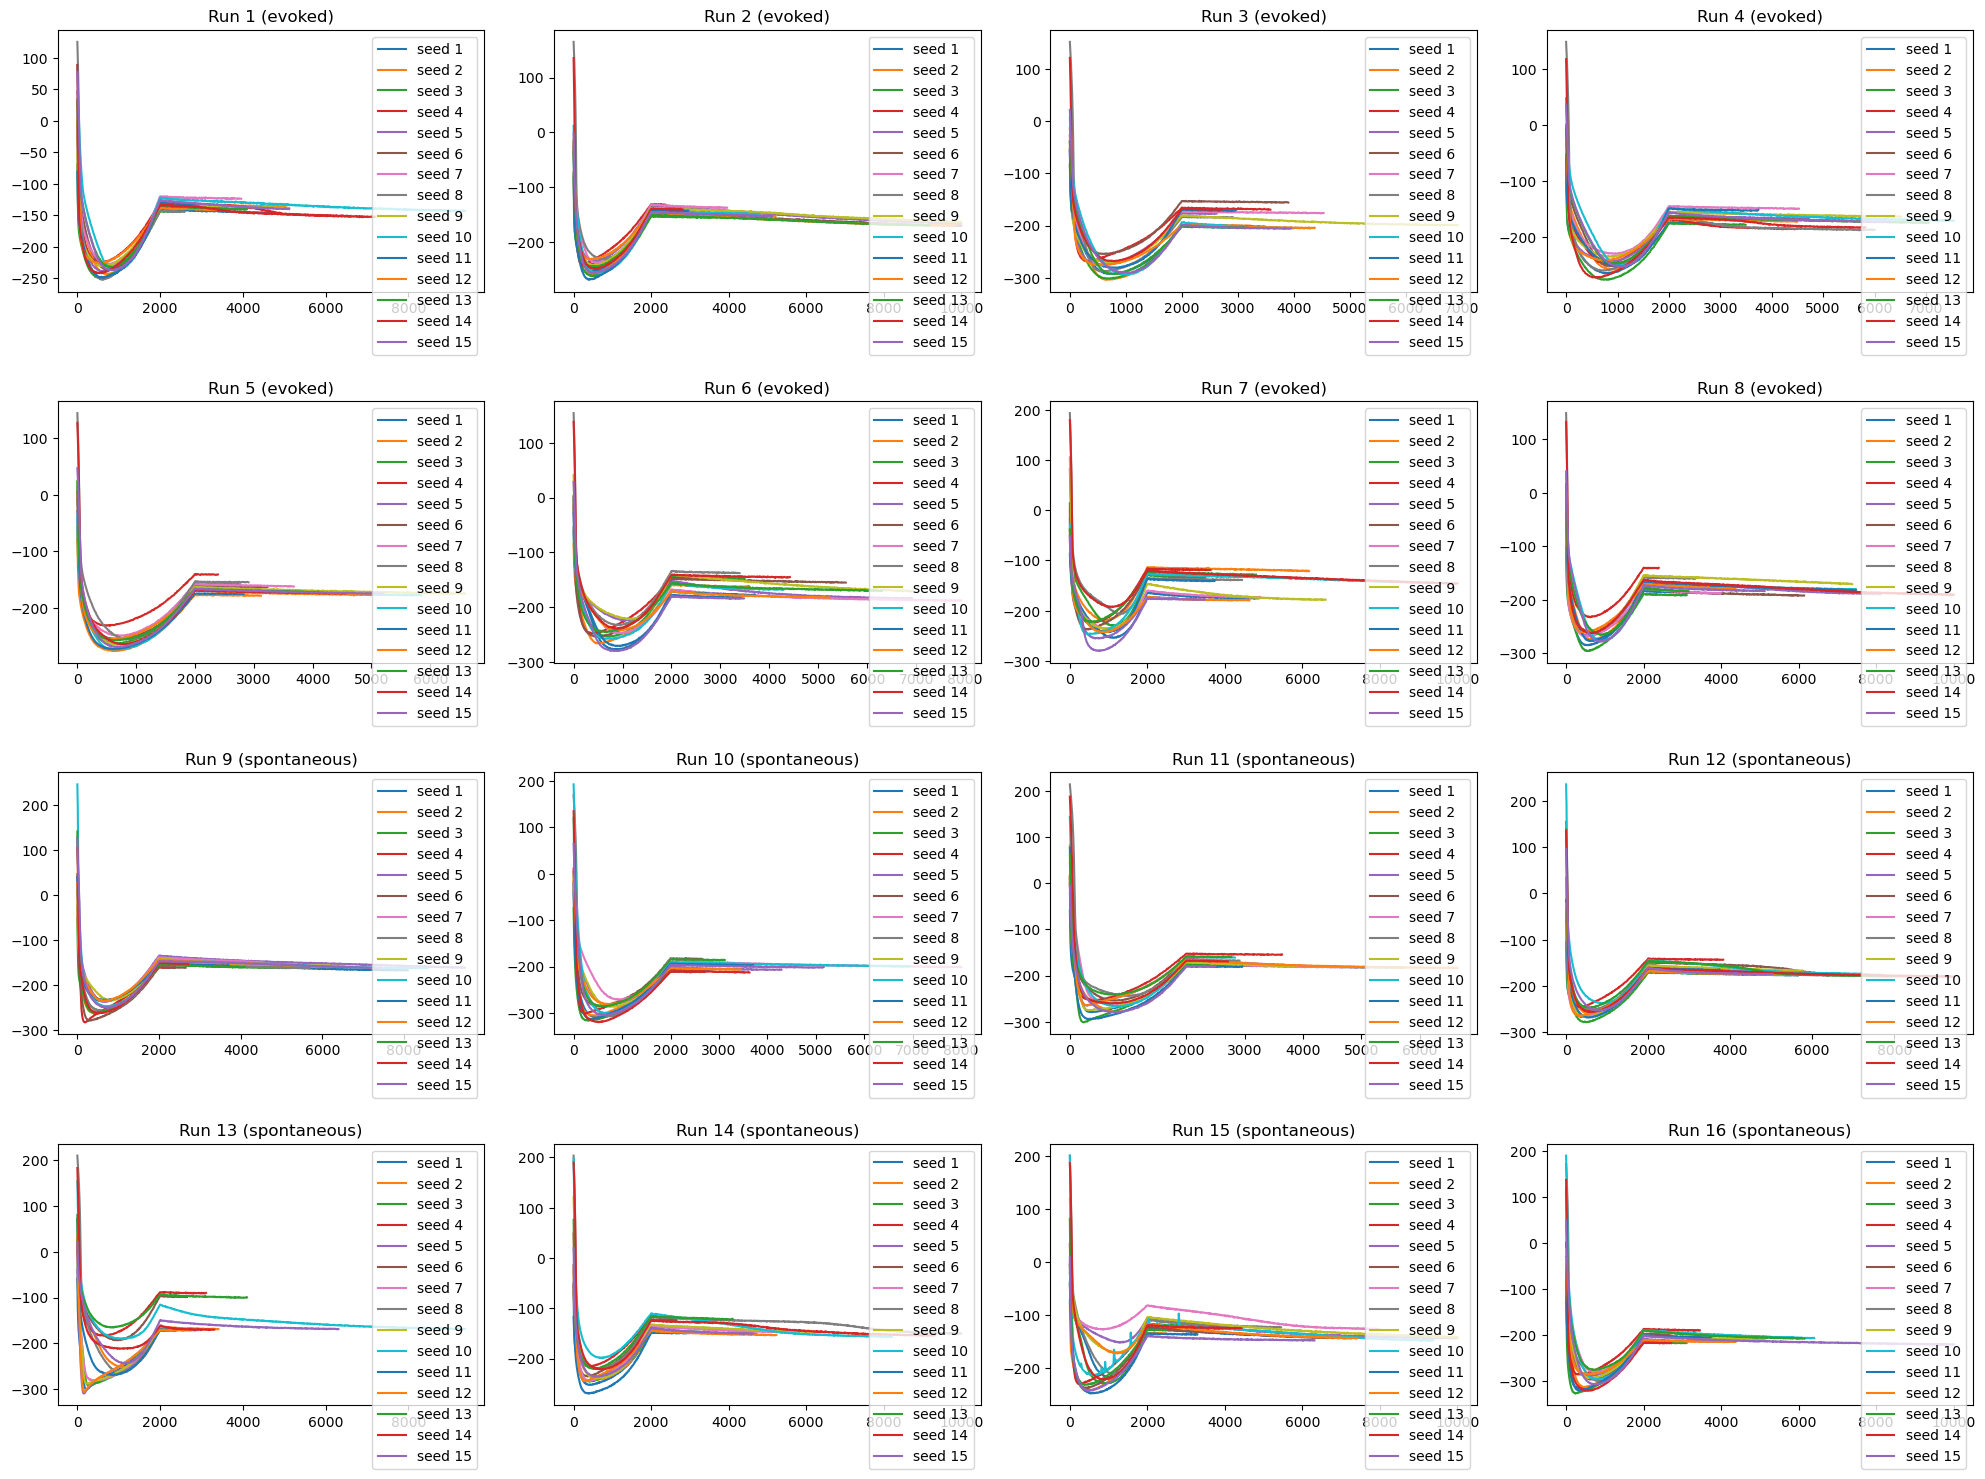

In [470]:
#plot all the loss traces. subplot per run and line per seed
fig, axs = plt.subplots(4, 4, figsize=(20, 15))
for i in range(1,17):
    ax = axs[(i-1)//4, (i-1)%4]
    for j in range(1,16):
            try:
                if loss_traces[(i,j)] is not None:
                    ax.plot(loss_traces[(i,j)][:,0],loss_traces[(i,j)][:,-1], label=f'seed {j}')
            except:
                pass
    ax.set_title(f'Run {i} ({paradigm_[i]})')
    ax.legend()
plt.tight_layout()
plt.show()

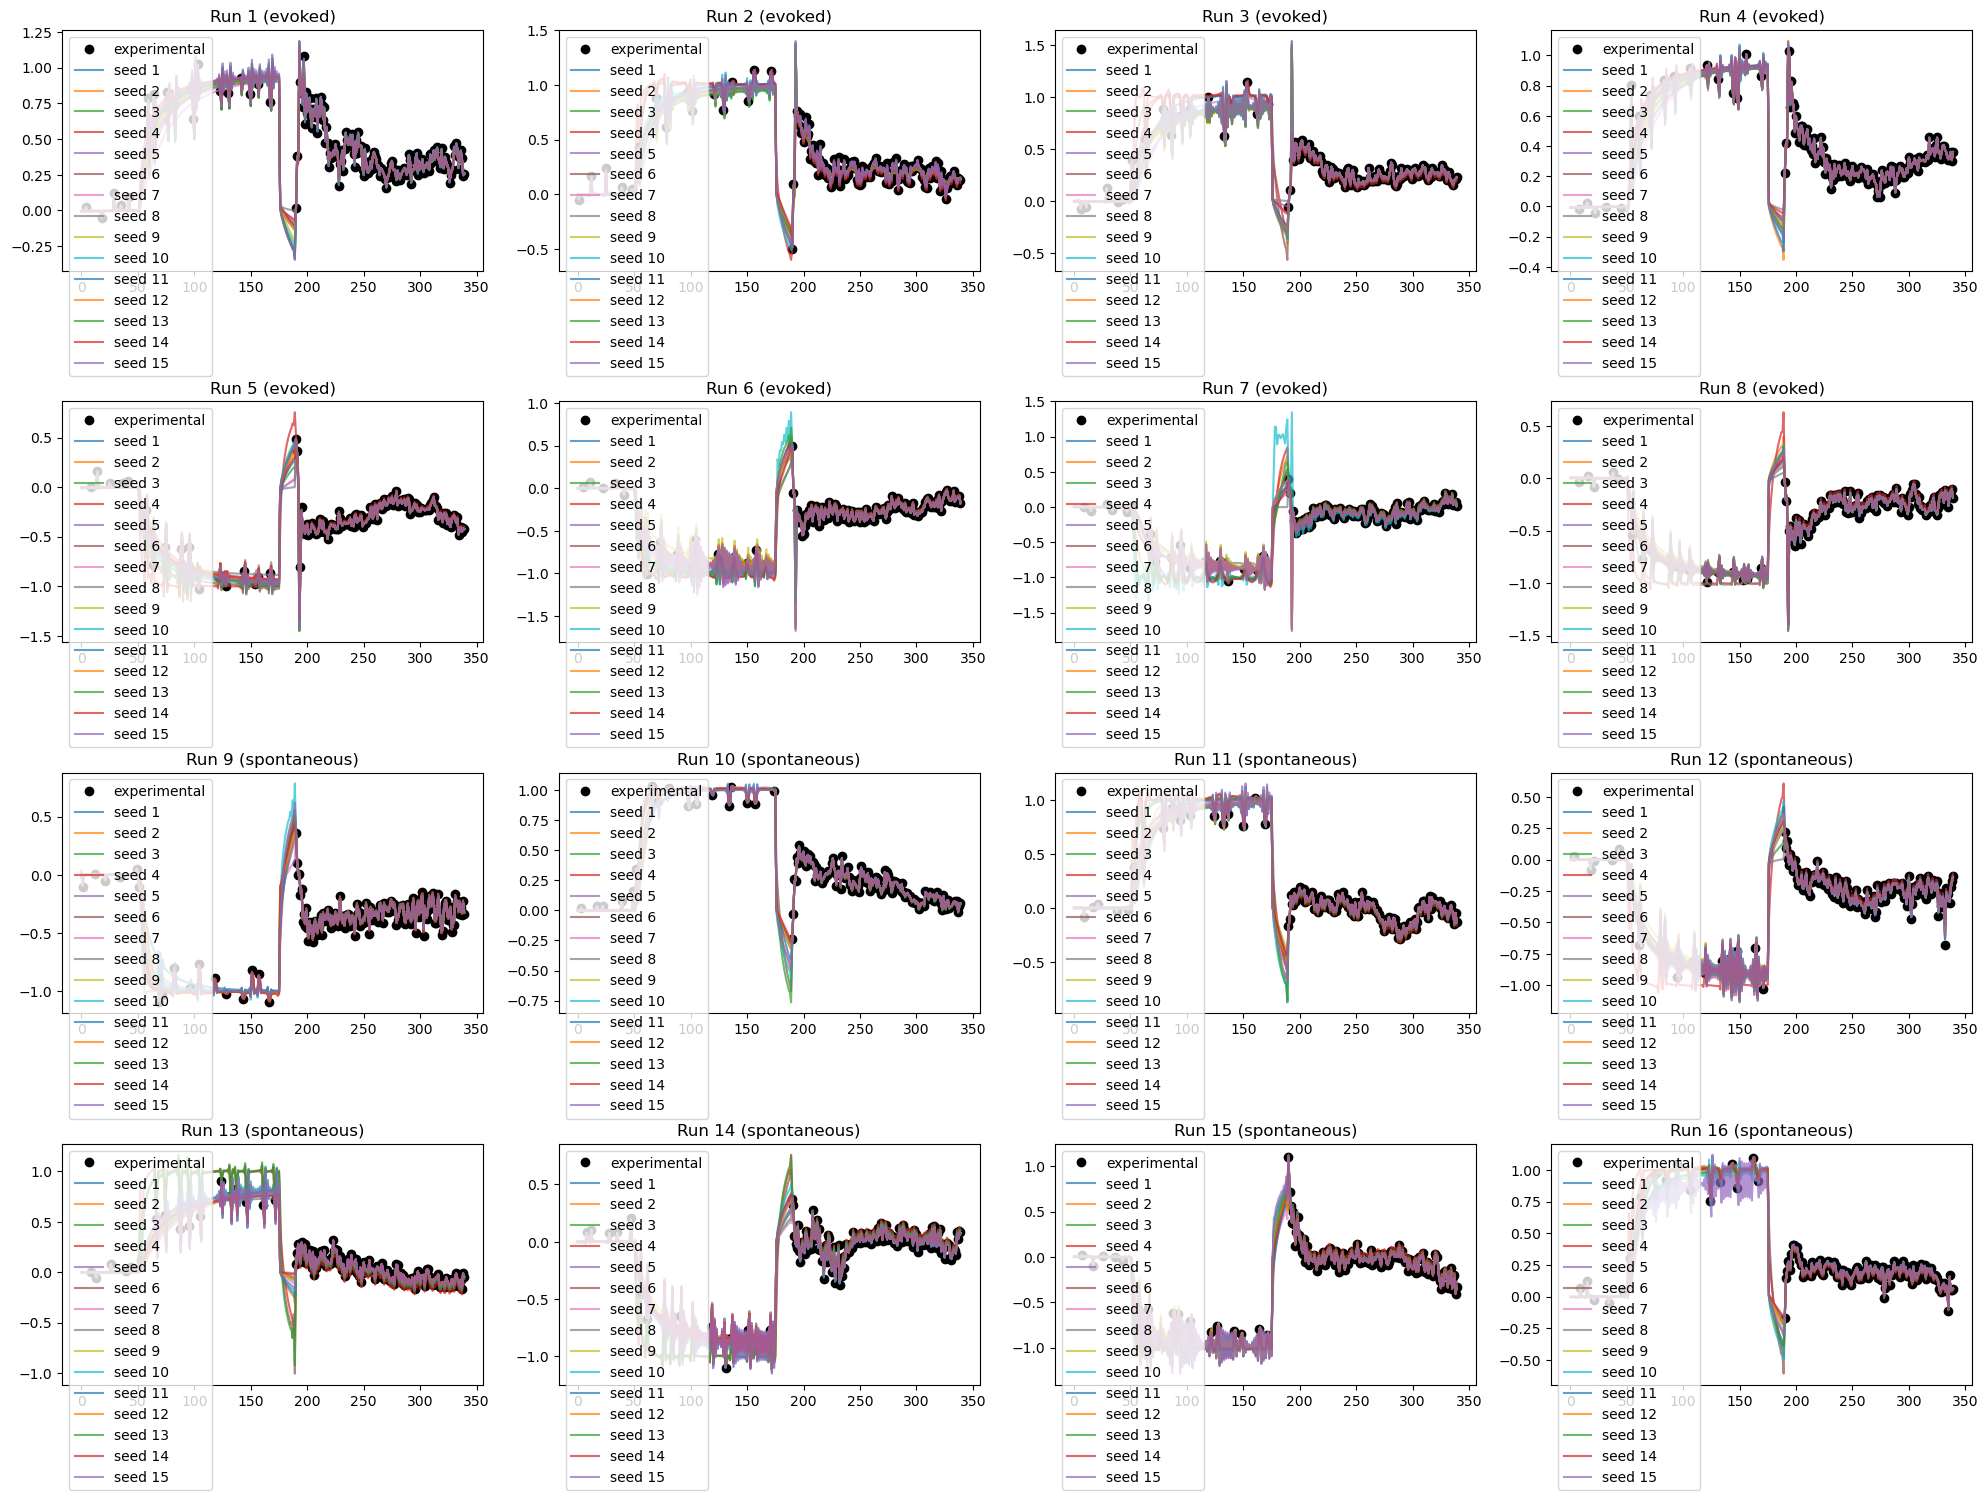

In [471]:
#plot output traces vs experimental data. subplot per run and line per seed
fig, axs = plt.subplots(4, 4, figsize=(20, 15))
for i in range(1,17):
    ax = axs[(i-1)//4, (i-1)%4]
    ax.plot(exp_datasets[i-1], 'o', label='experimental', color='black', linewidth=2)
    for j in range(1,16):
        if output_traces[(i,j)] is not None:
            ax.plot(output_traces[(i,j)], label=f'seed {j}', alpha=0.7)
    ax.set_title(f'Run {i} ({paradigm_[i]})')
    ax.legend()
plt.tight_layout()
plt.show()

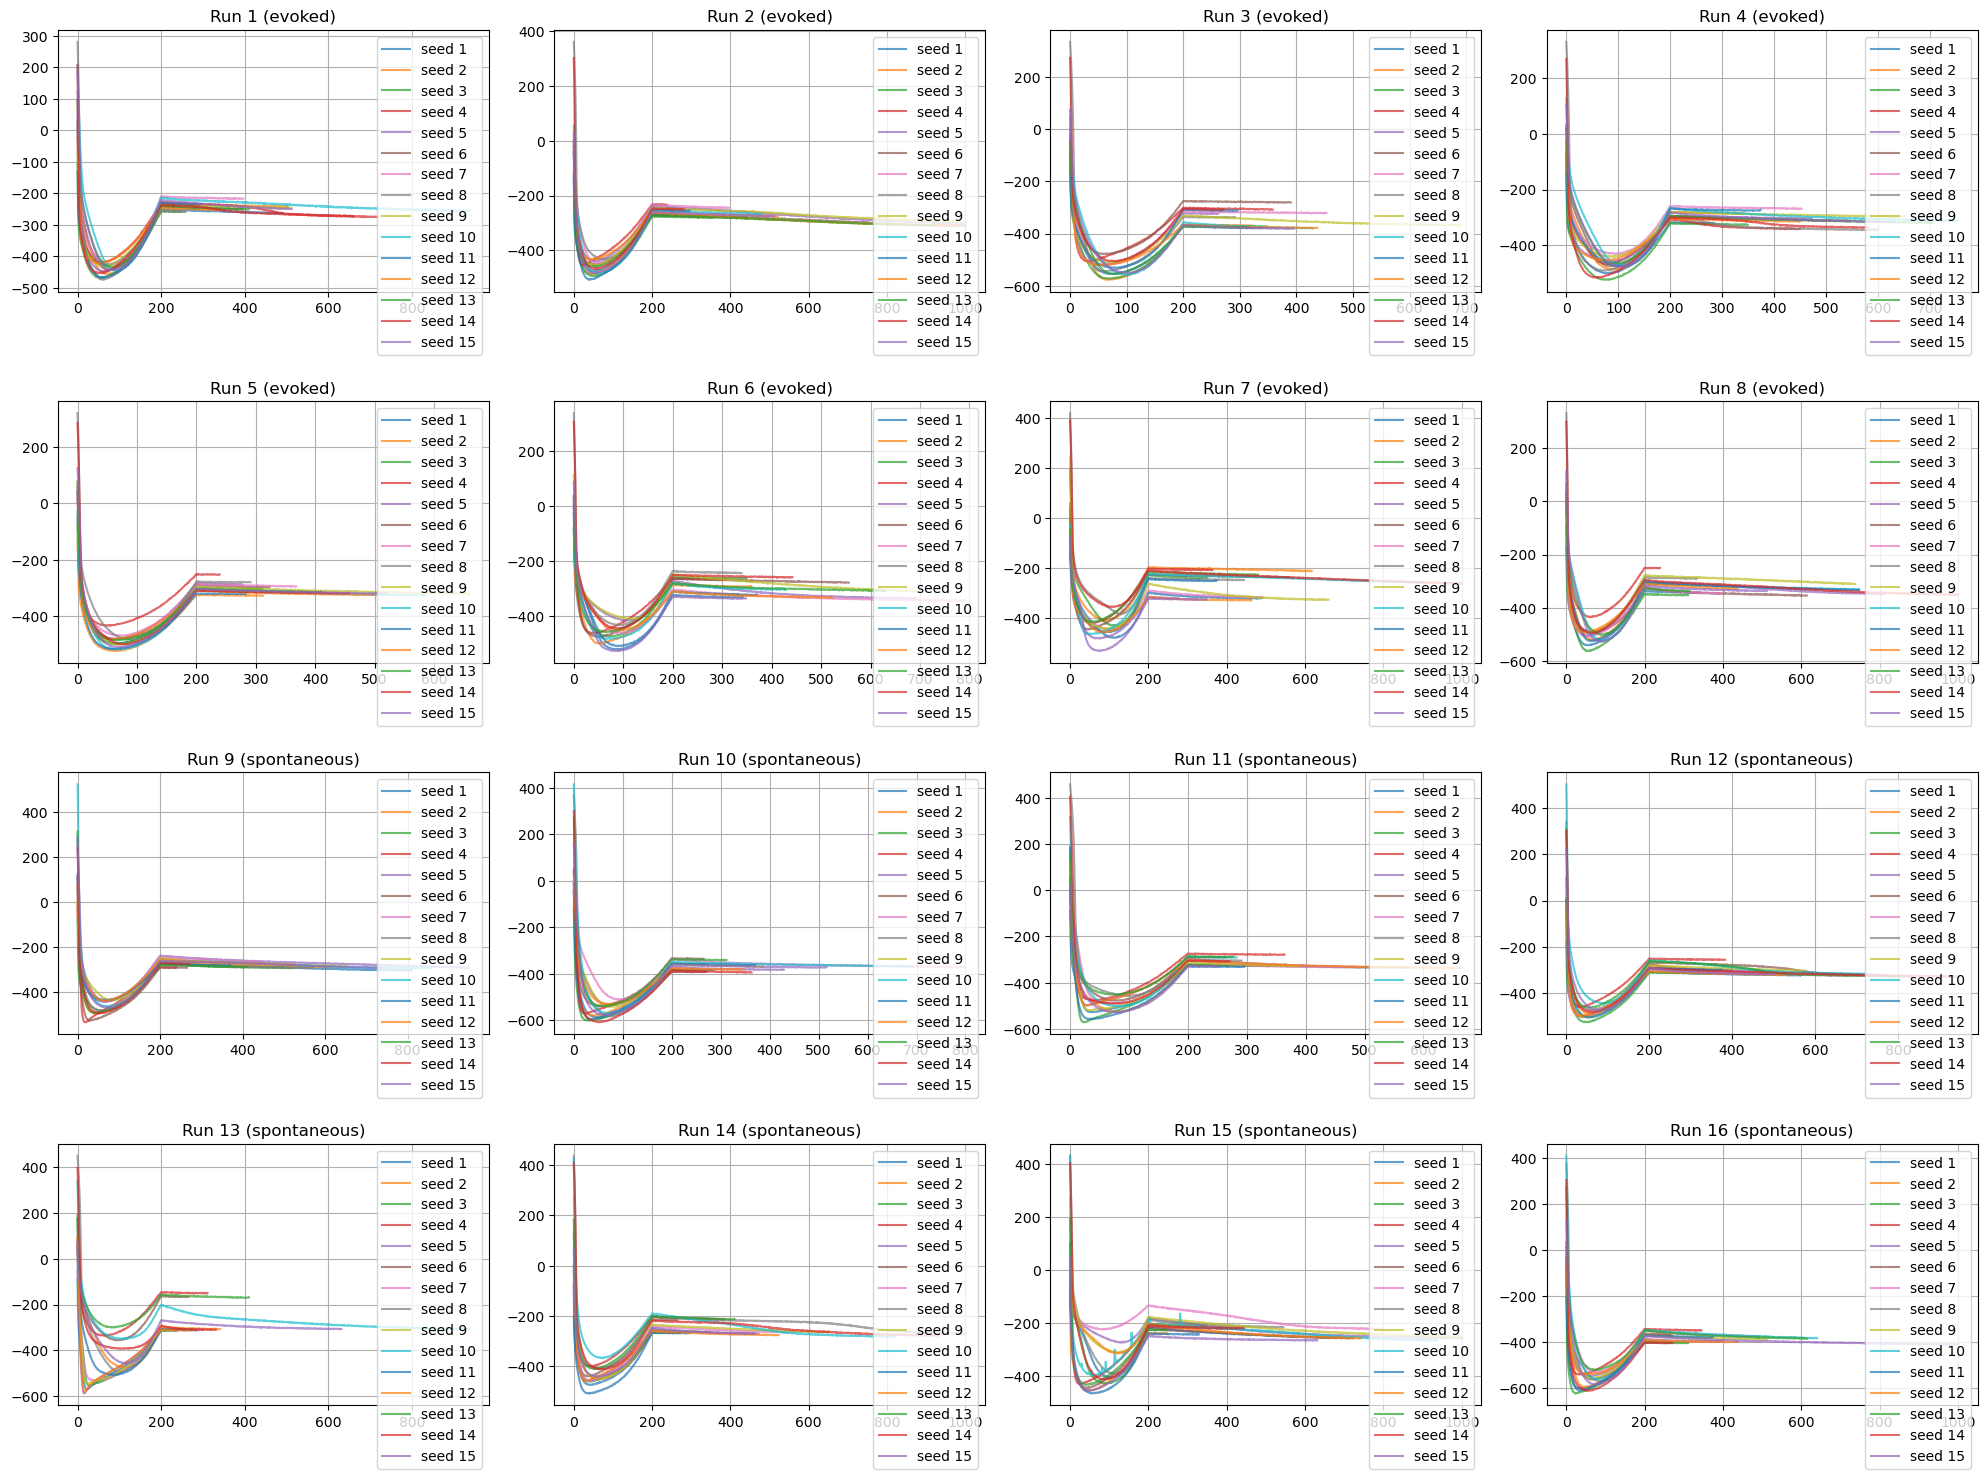

In [472]:
k = 6
VALID_AFTER = 2000
best_bics = []
best_seeds = []
fig, axs = plt.subplots(4, 4, figsize=(20, 15))
for i in range(1,17):
    ax = axs[(i-1)//4, (i-1)%4]
    n = np.sum(~np.isnan(exp_datasets[i-1]))
    # sum(~np.isnan(exp_data))
    these_bics = []
    best_bic = None
    best_seed = None
    for j in range(1,16):
        if output_traces[(i,j)] is not None:
            nll = loss_traces[(i,j)][:,1] * (n if LOSS_IS_PER_SAMPLE else 1)
            bic = 2*nll + k * np.log(n)
            # print(f'Run {i} seed {j} final BIC: {bic[-1]}')
            if np.max(loss_traces[(i,j)][:,0]) > VALID_AFTER:
                best_bic, best_seed = (bic[-1], j) if best_bic is None or bic[-1] < best_bic else (best_bic, best_seed)
                #TODO: remove the next
                these_bics.append(bic[-1])
            ax.plot(bic, label=f'seed {j}', alpha=0.7)
    # best_bics.append(min(these_bics) if len(these_bics)>0 else None)
    best_bics.append(best_bic)
    best_seeds.append(best_seed)
    ax.set_title(f'Run {i} ({paradigm_[i]})')
    ax.legend()
    ax.grid()
plt.tight_layout()
plt.show()

# for ii in range(1,17):
#     plt.subplot(4,4,1 if ii<8 else 2)
#     n = sum(~np.isnan(exp_data))
#     nll = loss_traces[ii][:,1] * (n if LOSS_IS_PER_SAMPLE else 1)
#     iters = loss_traces[ii][:,0]
#     bic = 2*nll + k * np.log(n)
#     plt.plot(iters,bic, label=f'{result_dirs[ii]} (final: {bic[-1]:.1f})')
#     clnn_bics.append(bic[-1])
#     plt.ylim([-500,-200])

In [473]:
# #plot every result in a separate subplot overlayed with     exp_data
# plt.figure(figsize=(12, 12))
# for ii, result_dir in enumerate(result_dirs):
#     # plt.subplot(2, len(result_dirs)//2, ii+1)
#     plt.subplot(4, 4, ii+1)
#     plt.plot(output_traces[ii], '.-' , label='model_output', linewidth=0.3)
#     plt.plot(exp_datasets[ii],'o', label='exp_data', linewidth=1, alpha=0.5)
#     plt.title(result_dir)
#     plt.ylim([-0.7,1.3])
#     plt.legend()
#     rmse = np.sqrt(np.nanmean((output_traces[ii] - exp_datasets[ii])**2))
#     plt.text(0.5, 0.1, f'RMSE: {rmse:.3f},\n neg-elbo: {loss_traces[ii][-1,1]:.3f}\n neg-elbo-min: {loss_traces[ii][201:,1].min():.3f}', transform=plt.gca().transAxes, ha='center')
# plt.show()

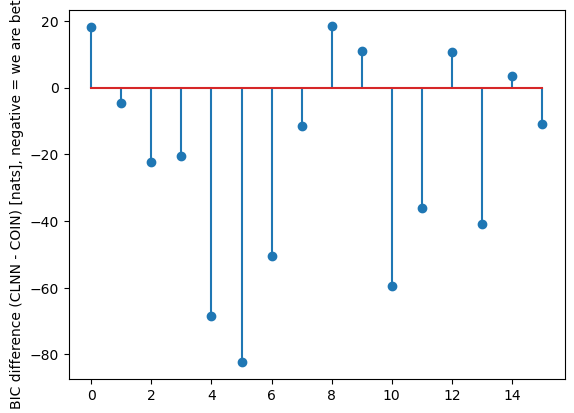

In [474]:
delta_bic = np.array(np.array(best_bics)-coin_bics)
np.savetxt('clnn_u.txt', np.array(best_bics))

plt.stem(delta_bic, 'o')
plt.ylabel('BIC difference (CLNN - COIN) [nats], negative = we are better')
np.savetxt('delta_bics.txt', delta_bic)

(array([1., 1., 1., 1., 2., 1., 1., 3., 1., 4.]),
 array([-82.3924899 , -72.32201187, -62.25153383, -52.1810558 ,
        -42.11057777, -32.04009974, -21.96962171, -11.89914368,
         -1.82866565,   8.24181239,  18.31229042]),
 <BarContainer object of 10 artists>)

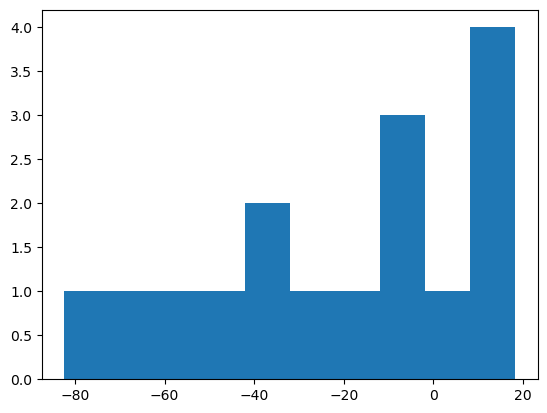

In [475]:
plt.hist(delta_bic)

In [476]:
best_seeds

[4, 6, 15, 8, 2, 7, 12, 6, 1, 4, 12, 14, 3, 10, 10, 15]

In [477]:
these_bics

[-397.3105695539784,
 -370.0007816108734,
 -403.23594606385967,
 -348.88683304266414,
 -396.41432931929324,
 -367.4719929311295,
 -376.197343715454,
 -397.5728118209383,
 -388.13468056333335,
 -382.0640048702796,
 -376.8816359624197,
 -398.8352109073091,
 -384.5770047213361,
 -403.8263840996105,
 -409.38827174350985]

TypeError: 'NoneType' object is not subscriptable

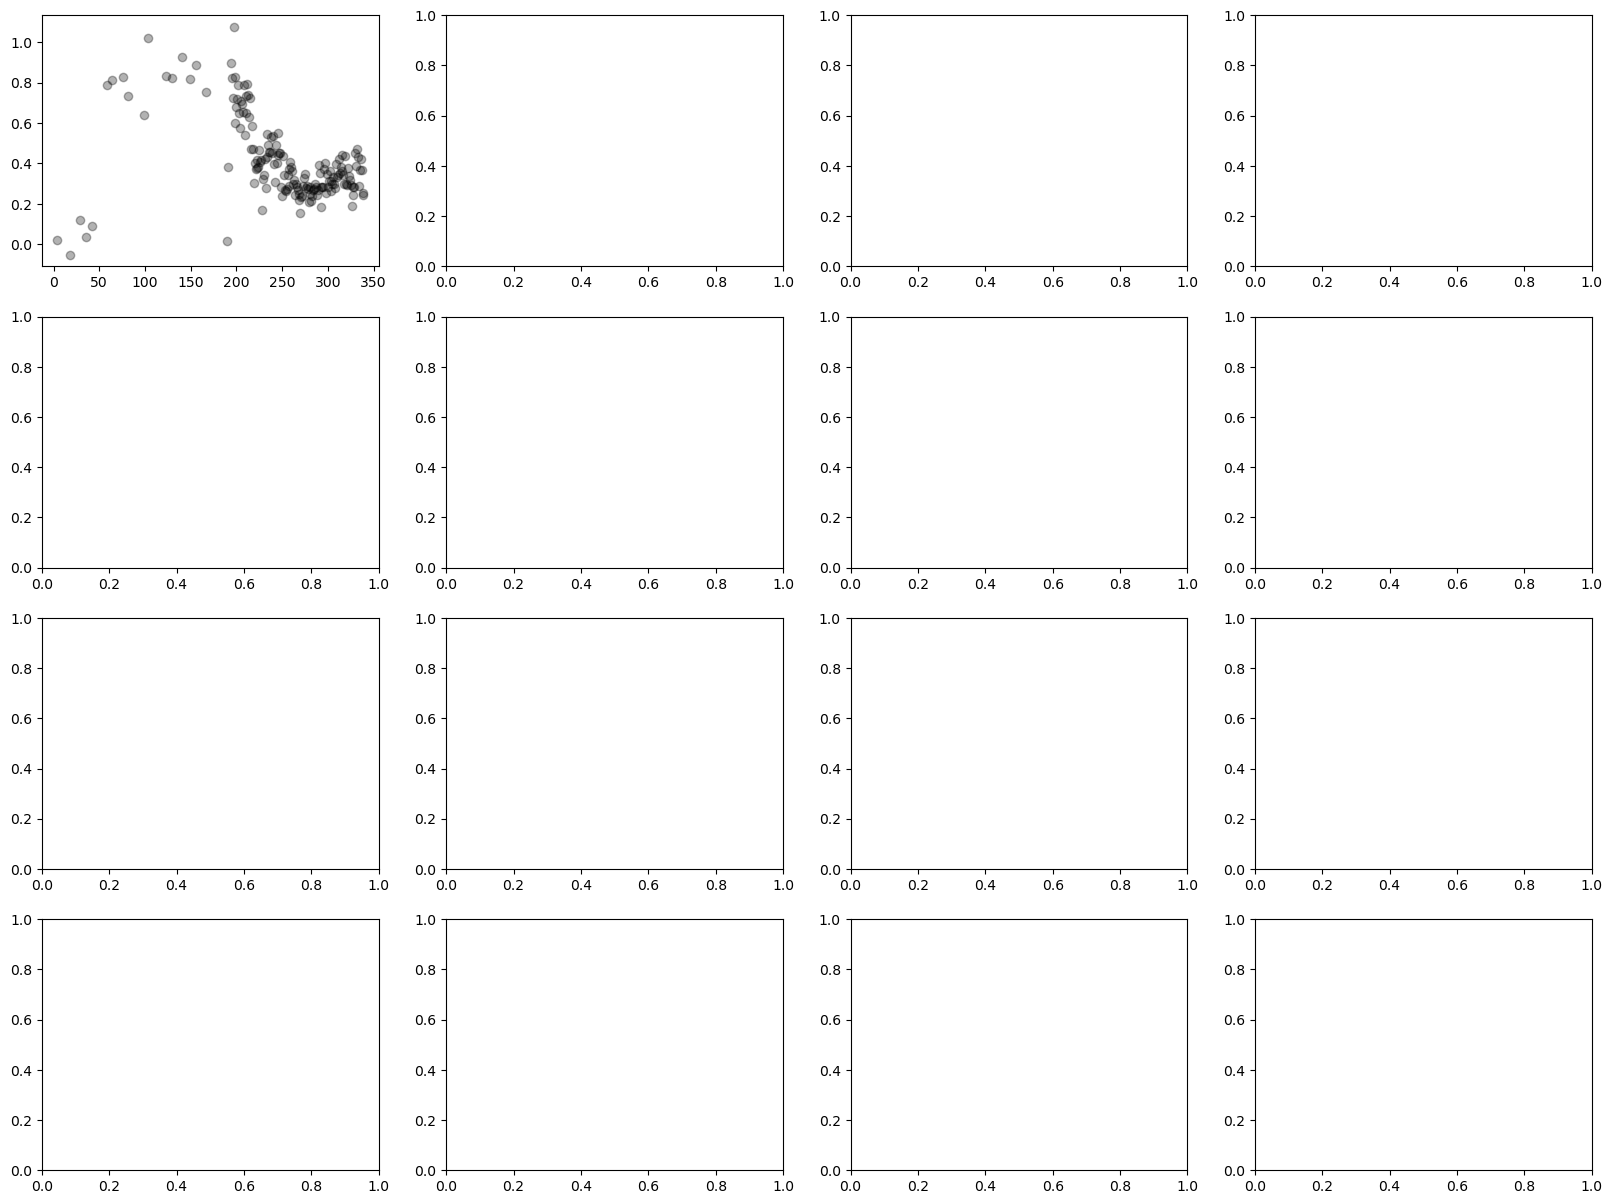

In [478]:
#plot output traces vs experimental data. subplot per run and line per seed
fig, axs = plt.subplots(4, 4, figsize=(20, 15))
for i in range(1,17):
    ax = axs[(i-1)//4, (i-1)%4]
    ax.plot(exp_datasets[i-1], 'o', label='experimental', color='black', linewidth=2, alpha=0.3)
    j = 1 # best_seeds[i-1]
    if output_traces[(i,j)] is not None:
        # ax.plot(output_traces[(i,j)], label=f'seed {j}', alpha=0.7)
        prior_a = prior_out_batch[(i,j)]['as']
        posterior_a = posterior_out_batch[(i,j)]['as']
        ax.plot(np.mean(posterior_a, axis=1), label=f' (posterior mean)', linestyle='-', alpha=0.7, linewidth=3)
        ax.plot(np.mean(prior_a, axis=1), label=f' (prior mean)', linestyle='--', alpha=0.7, linewidth=4)
        if i in [8,12]:
            np.savetxt(f'run{i}_prior.txt', np.mean(prior_a, axis=1))
            np.savetxt(f'run{i}_posterior.txt', np.mean(posterior_a, axis=1))
            np.savetxt(f'run{i}_exp.txt', exp_datasets[i-1])
            np.savetxt(f'run{i}_prior0123.txt', prior_a[:,0:4])

    ax.set_title(f'Run {i} ({paradigm_[i]})')
    ax.set_ylim([-1.2,1.2])
    # ax.legend()
plt.tight_layout()
ax.legend()
plt.show()

TypeError: 'NoneType' object is not subscriptable

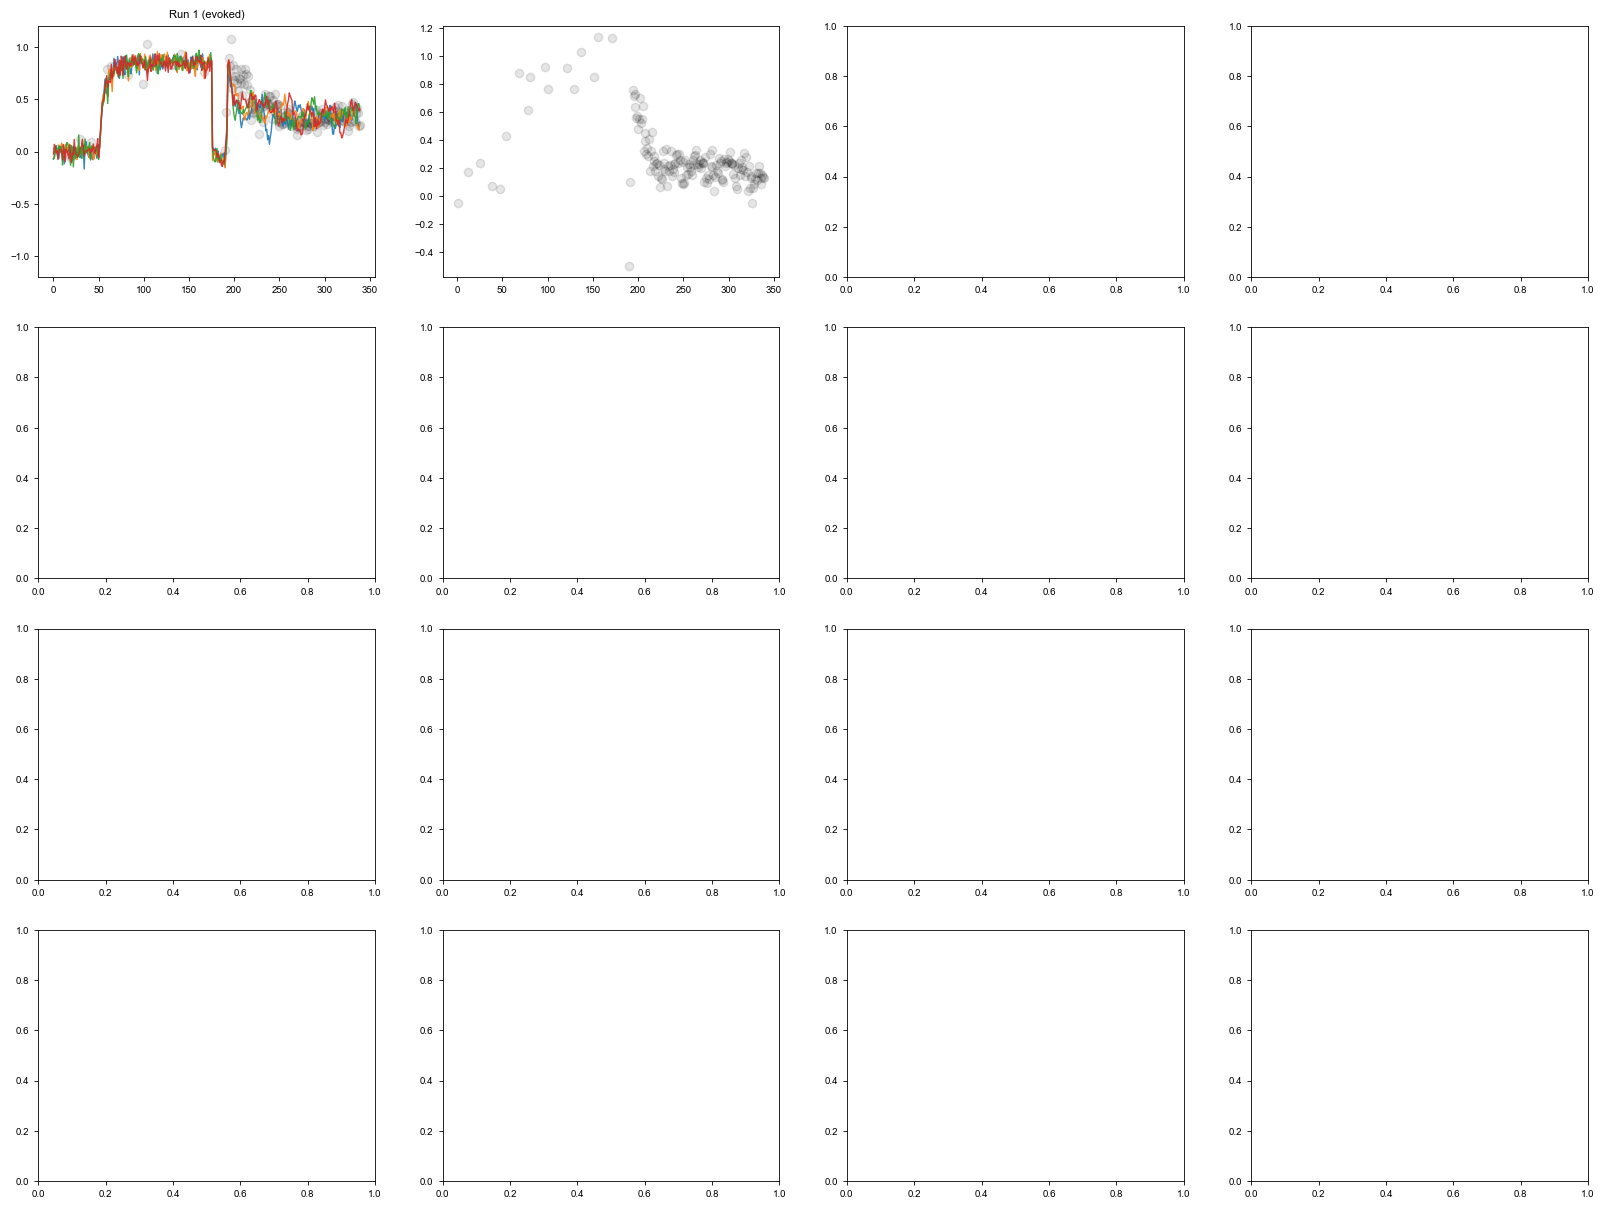

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 15))
for i in range(1,17):
    ax = axs[(i-1)//4, (i-1)%4]
    ax.plot(exp_datasets[i-1], 'o', label='experimental', color='black', linewidth=2, alpha=0.1)
    j = best_seeds[i-1]
    if output_traces[(i,j)] is not None:
        # ax.plot(output_traces[(i,j)], label=f'seed {j}', alpha=0.7)
        prior_a = prior_out_batch[(i,j)]['as']
        posterior_a = posterior_out_batch[(i,j)]['as']
        # ax.plot(np.mean(posterior_a, axis=1), label=f' (posterior mean)', linestyle='-', alpha=0.7, linewidth=3)
        ax.plot(prior_a[:,:4], label=f' (prior mean)', linestyle='-', alpha=0.9, linewidth=1)

    ax.set_title(f'Run {i} ({paradigm_[i]})')
    ax.set_ylim([-1.2,1.2])
    # ax.legend()
plt.tight_layout()
ax.legend()
plt.show()

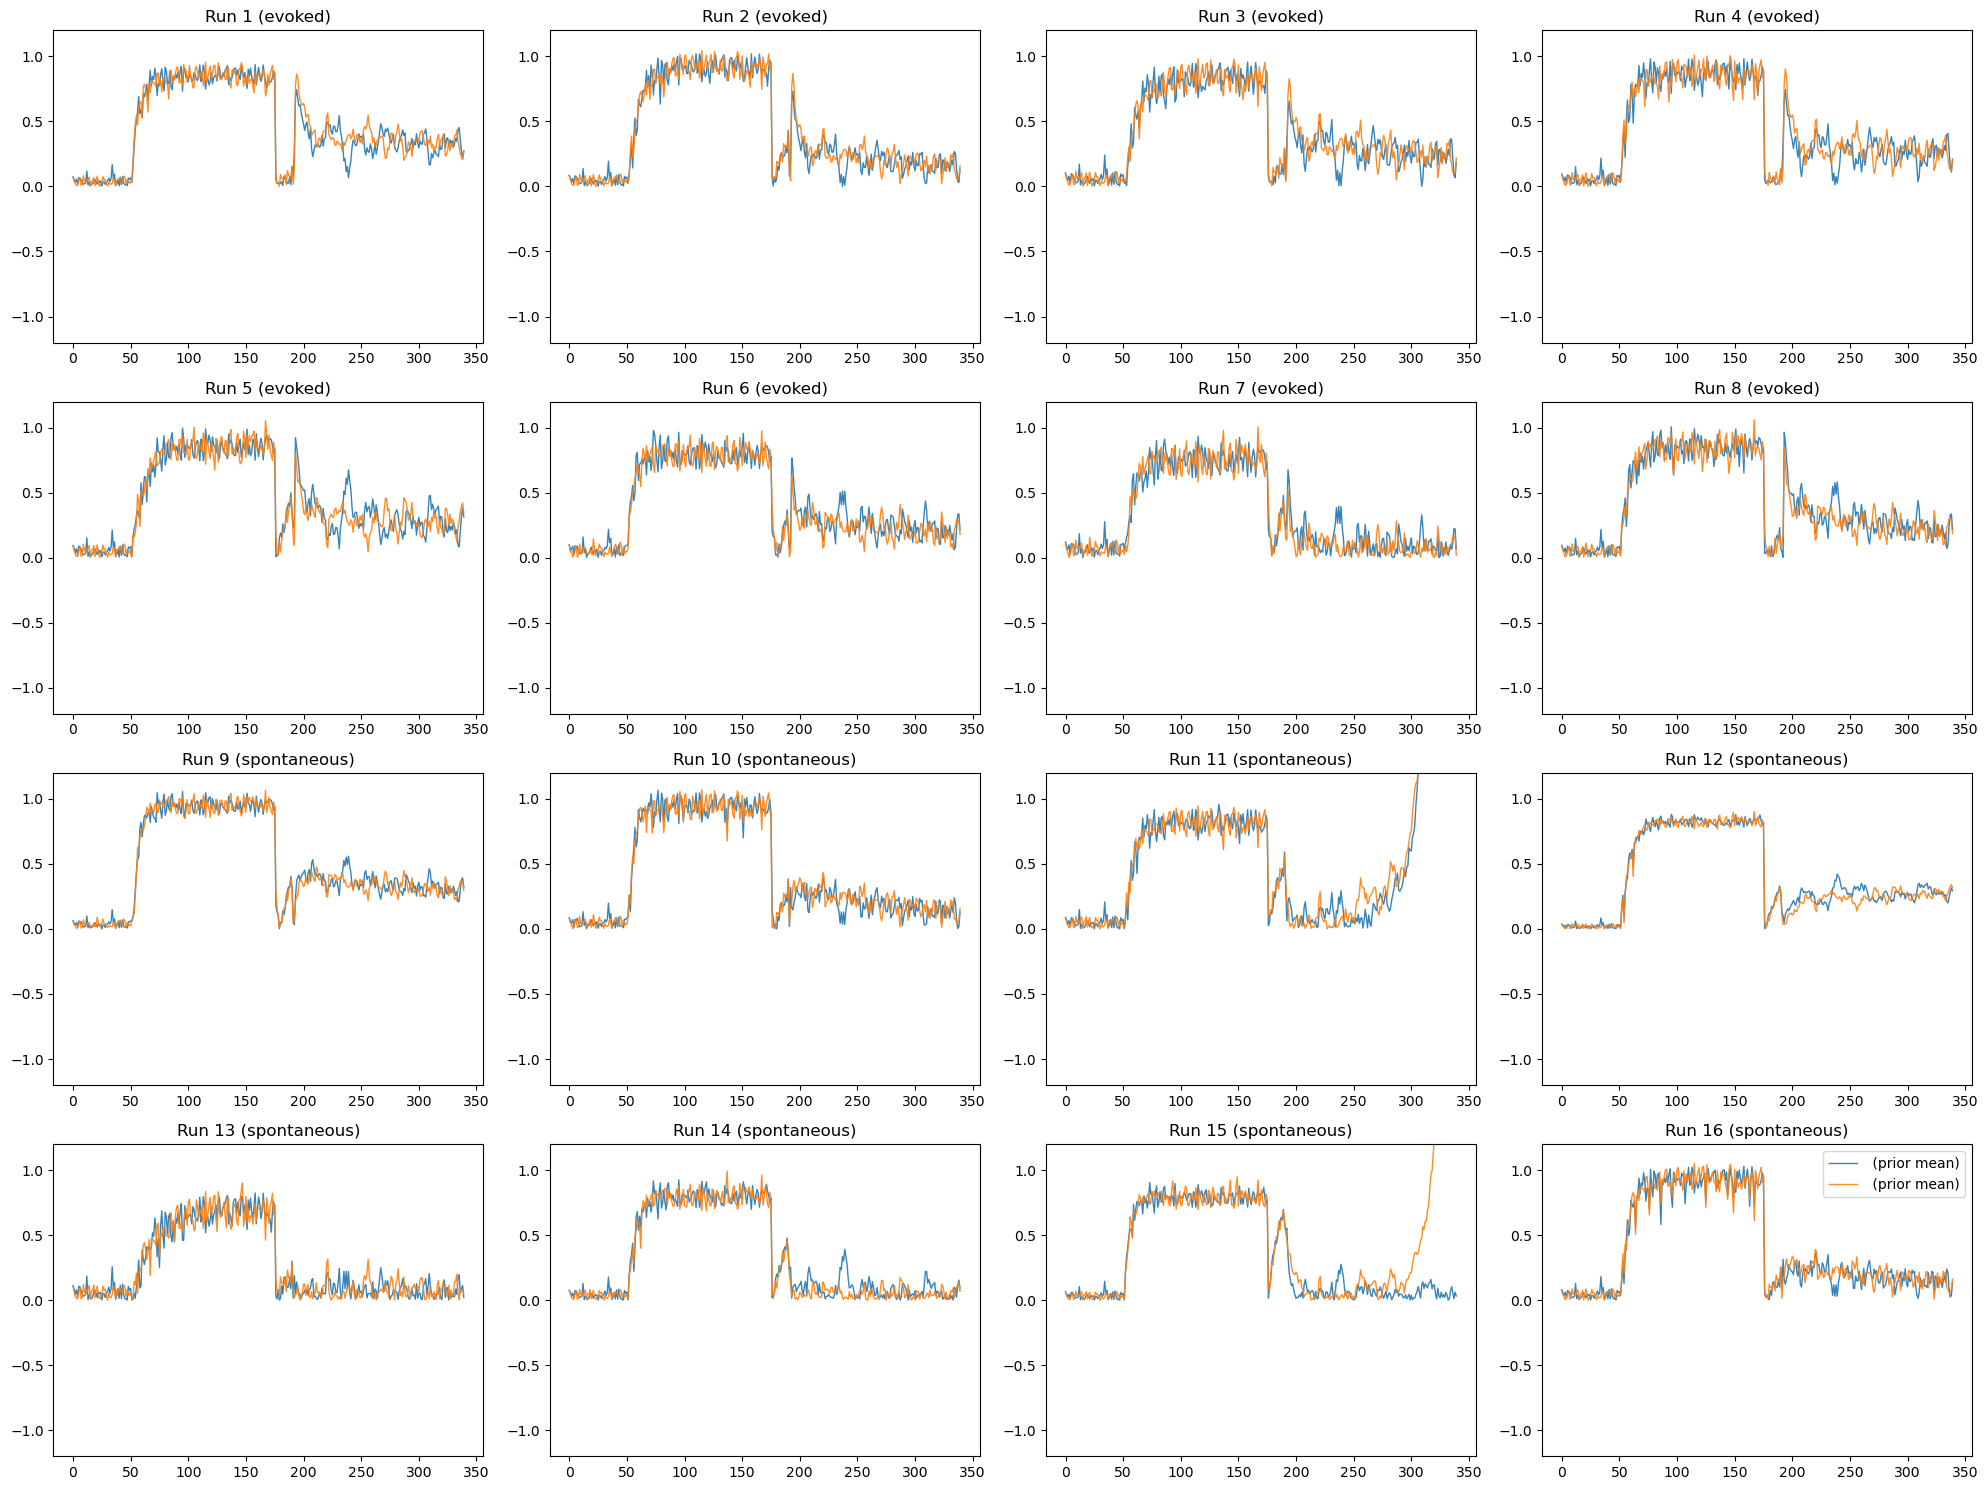

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 15))
for i in range(1,17):
    ax = axs[(i-1)//4, (i-1)%4]
    # ax.plot(exp_datasets[i-1], 'o', label='experimental', color='black', linewidth=2, alpha=0.1)
    j = best_seeds[i-1]
    if output_traces[(i,j)] is not None:
        # ax.plot(output_traces[(i,j)], label=f'seed {j}', alpha=0.7)
        prior_a = prior_out_batch[(i,j)]['as']
        posterior_a = posterior_out_batch[(i,j)]['as']
        # ax.plot(np.mean(posterior_a, axis=1), label=f' (posterior mean)', linestyle='-', alpha=0.7, linewidth=3)
        ax.plot(prior_a[:,:2]*np.sign(prior_a[:,:2]), label=f' (prior mean)', linestyle='-', alpha=0.9, linewidth=1)

    ax.set_title(f'Run {i} ({paradigm_[i]})')
    ax.set_ylim([-1.2,1.2])
    # ax.legend()
plt.tight_layout()
ax.legend()
plt.show()

In [ ]:
coin_bics

array([-292.9898, -305.1738, -358.4313, -323.1435, -258.6472, -261.7511,
       -278.125 , -341.4957, -322.0862, -405.7469, -276.3096, -292.257 ,
       -324.4123, -241.2675, -269.2641, -398.4167])